## Part I - Common Analysis
### US County to analyze: Oklahoma, Oklahoma.

In [1]:
#importing libraries
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests
pd.options.mode.chained_assignment = None
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

import requests
import json

## Step 0: Data acquisition

### 0.1 Read files

In [2]:
#We read the 3 input sources
raw_us_cases = pd.read_csv('../data_raw/RAW_us_confirmed_cases.csv')
mask_use = pd.read_csv('../data_raw/mask-use-by-county.csv')
mask_mandates = pd.read_csv('../data_raw/U.S._State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_August_15__2021_by_County_by_Day.csv')
#The US county to analyze is Oklahoma, Oklahoma, we want to find out what is the FIPS for this county
raw_us_cases[(raw_us_cases['Province_State']=='Oklahoma') & (raw_us_cases['Admin2']=='Oklahoma')]['FIPS']
#We find that Oklahoma County, Oklahoma's FIPS is 40109

2268    40109.0
Name: FIPS, dtype: float64

### 0.2: Data manipulation

#### Clean *raw_us_cases* 
We would like to have a table with a date per row, so we filter for Oklahoma, OK and then we unpivot the table. We also want to filter such that it's between February 1, 2020 through October 1, 2021

In [3]:
#We identify and remove unwanted columns
raw_us_cases.drop(columns = ['UID','iso2','iso3','code3', 'Country_Region', 'Lat', 'Long_','Combined_Key'],inplace=True)
#We filter for Oklahoma, OK and then we unpivot the table
raw_us_cases_OK = raw_us_cases[(raw_us_cases['Province_State']=='Oklahoma') & (raw_us_cases['Admin2']=='Oklahoma')]
us_cases_OK = pd.melt(raw_us_cases_OK, id_vars = ['Province_State', 'Admin2','FIPS'],var_name='date',value_name='cases')
#We filter out the dates that are not between February 1, 2020 through October 1, 2021
us_cases_OK['date'] = pd.to_datetime(us_cases_OK['date'])
us_cases_OK = us_cases_OK[(us_cases_OK['date'] >= '2020-02-01') & (us_cases_OK['date'] <= '2021-10-01')]

#### Clean *mask_use*
We only want data from Oklahoma, OK (40109)

In [4]:
mask_use_OK = mask_use[(mask_use['COUNTYFP']==40109)]


#### Clean *mask_mandates*
We only want data from Oklahoma, OK (40109). We also want to filter such that it's between February 1, 2020 through October 1, 2021

In [5]:
#We filter for Oklahoma, OK
mask_mandates_copy = mask_mandates.copy()
mask_mandates = mask_mandates[(mask_mandates['FIPS_State']==40)&(mask_mandates['FIPS_County']==109)]
#We filter out the dates that are not between February 1, 2020 through October 1, 2021
mask_mandates['date'] = pd.to_datetime(mask_mandates['date'])
mask_mandates_OK = mask_mandates[(mask_mandates['date'] >= '2020-02-01') & (mask_mandates['date'] <= '2021-10-01')]


### Save processed files into the *data_clean* folder

In [6]:
us_cases_OK.to_csv('../data_clean/us_cases_OK.csv')
mask_use_OK.to_csv('../data_clean/mask_use_OK.csv')
mask_mandates_OK.to_csv('../data_clean/mask_mandates_OK.csv')


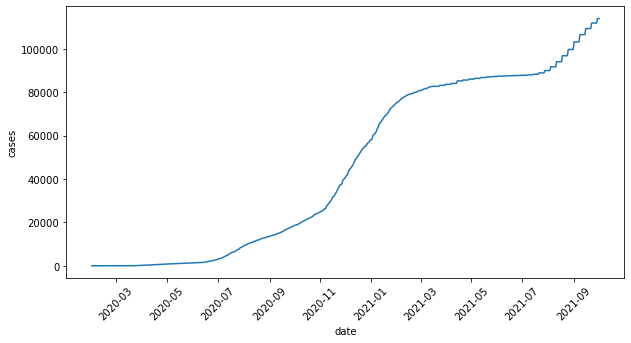

In [7]:
plt.figure(figsize=(10,5))
chart = sns.lineplot(data=us_cases_OK, x="date", y="cases")
chart.tick_params(axis='x', labelrotation = 45)

## Step 1: Analyze
We want to respond: How did masking policies change the progression of confirmed COVID-19 cases from February 1, 2020 through October 1, 2021?


We will begin to analyze and inspect the data for our specific County, this will allow us to know how to tackle this problem and respond the question



### 1.1: Analyze Oklahoma County, OK data

We first want to know how the masking policies were handled in this county. We count the number of days with and without mask enforcement

In [8]:
mask_mandates_OK.groupby('order_code').count()

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
order_code,,,,,,,,,
2,493,493,493,493,493,0,0,0,0


We note that from the 493 days of data we have, there are no days with mask mandates imposed. Hence, it will be tougher to directly answer the initial question. Still, we will then try to understand how does "voluntary masking" looks like and how can we model it. 

### Checking mask use survey data

Given that we have no mask mandate for the whole time period, we will only work with the other two data sources we have left. First, we want to have some initial intuition about how possible is it that there could be high voluntary masking in this state. We have the mask use survey that can give us this perspective

In [9]:
mask_use_OK

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
2185,40109,0.096,0.064,0.097,0.225,0.518


From this datasource, we notice that even though this state does not have regulations or enforcement for mask use, there is reason to believe that there could be "voluntary masking" within the people of this county. We can conclude this given that almost 75% of the estimated share of people of this county would **"frequently"** or **"always"** wear a mask in public. 




Now that we have a better intuition of what is going on, where we know that there is no enforcement but a reason to believe that there is voluntary masking, we proceed to analyze the case dataset directly

### Prepare Oklahoma County cases data for time series analysis

We currently have cummulative cases, given that we want to analyze the time series, it is more convenient to convert this into daily new cases.

In [10]:
us_cases_OK['daily_cases'] = us_cases_OK['cases'] - us_cases_OK.shift(periods=1)['cases']
daily_us_cases_OK = us_cases_OK.fillna(0)
daily_us_cases_OK

,Province_State,Admin2,FIPS,date,cases,daily_cases
10,Oklahoma,Oklahoma,40109.0,2020-02-01,0,0.0
11,Oklahoma,Oklahoma,40109.0,2020-02-02,0,0.0
12,Oklahoma,Oklahoma,40109.0,2020-02-03,0,0.0
13,Oklahoma,Oklahoma,40109.0,2020-02-04,0,0.0
14,Oklahoma,Oklahoma,40109.0,2020-02-05,0,0.0
...,...,...,...,...,...,...
614,Oklahoma,Oklahoma,40109.0,2021-09-27,111894,0.0
615,Oklahoma,Oklahoma,40109.0,2021-09-28,111894,0.0
616,Oklahoma,Oklahoma,40109.0,2021-09-29,113912,2018.0
617,Oklahoma,Oklahoma,40109.0,2021-09-30,113912,0.0


We graph this daily behaviour

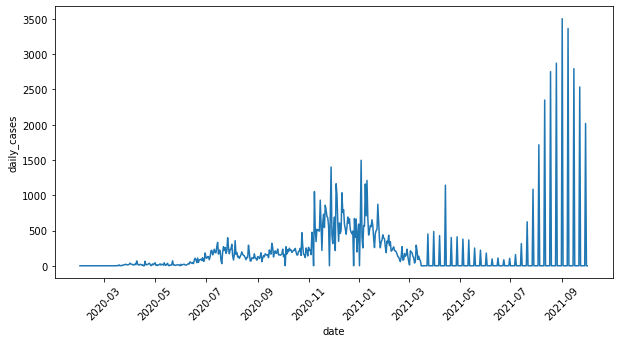

In [11]:
plt.figure(figsize=(10,5))
chart = sns.lineplot(data=daily_us_cases_OK, x="date", y="daily_cases")
chart.tick_params(axis='x', labelrotation = 45)

We can observe very agressive spikes throughout the graph, we note that it has a clear weekly trend that we would like to smooth out, we can do so working with moving averages. We do rolling windows for 2, 5 and 7 days to understand which strikes a good balance in the graph. **The idea to smooth the data was shared with me by Charles Reinertson**

In [12]:
daily_us_cases_OK['daily_cases_ma_2'] = daily_us_cases_OK['daily_cases'].rolling(2).mean()
daily_us_cases_OK['daily_cases_ma_5'] = daily_us_cases_OK['daily_cases'].rolling(5).mean()
daily_us_cases_OK['daily_cases_ma_7'] = daily_us_cases_OK['daily_cases'].rolling(7).mean()
daily_us_cases_OK = daily_us_cases_OK.fillna(0)

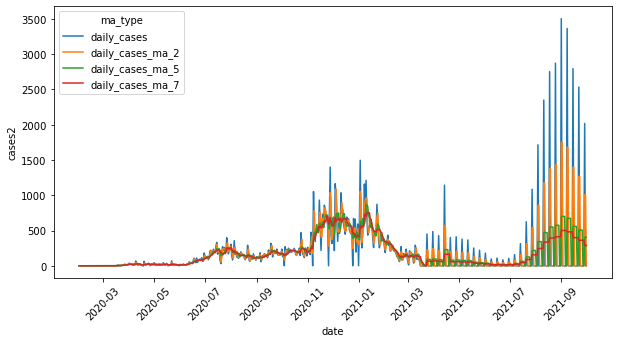

In [13]:
daily_us_cases_OK_ma = pd.melt(daily_us_cases_OK, id_vars = ['Province_State', 'Admin2', 'FIPS','date','cases'],var_name='ma_type', value_name='cases2')
plt.figure(figsize=(10,5))
chart = sns.lineplot(data=daily_us_cases_OK_ma, x="date", y="cases2",hue='ma_type')
chart.tick_params(axis='x', labelrotation = 45)

We conclude that a window of 7 days is able to reduce the agressive spikes trend into a smoother line we can better analyze.

## How did masking policies change the progression of confirmed COVID-19 cases from February 1, 2020 through October 1, 2021?

Given that we want to understand how does "voluntary masking" looks like and how can we model it, we come with the following analysis proposals:
    
    1. Check if there is a similar county in Oklahoma state that did impose a mask mandate, compare between these two counties to understand the difference between voluntary and forced masking, assuming that counties within a state behave similarly.
    2. Search in the www for dates regarding masking recommendation/mandates and vaccination availability at a national, state and county level. We would cross these dates with our time series analysis to understand if voluntary masking or vaccination has a clear impact on cases, if so what effect can we see?

### Approach #1: Check for apples-to-apples county within OK state

In [14]:
#Filter for only Oklahoma
mask_mandates_copy = mask_mandates_copy[(mask_mandates_copy['FIPS_State']==40)]
#Find if any county has order_code ==1 
mask_mandates_copy.groupby('order_code').count()

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
order_code,,,,,,,,,
2,37961,37961,37961,37961,37961,0,0,0,0


We observe that the whole state of Oklahoma did not enforce any type of masking mandate, hence, we do not have an ideal county to compare with. We move on to the second approach

### Approach #2: Date association cases vs. mask mandates/vaccination availability at a national, state and county level. 

### Mask mandates

First let's investigate mask mandates at a national, state and county levels.

Doing a thorough investigation about mask mandates, we have found two important sources of information, one at a national level and one at a county level. 

According to the U.S. Department of Defense, we have the following dates for mask mandates at a national level:

- First Mask Mandate: April 2020
- Mask Mandate is removed: January 2021
- 2nd Mask Mandate: 1 February 2021
- 2nd Mask Mandate is remove: June 10, 2021
- Mask Mandate closed spaces is removed: February 25, 2022

We additionally found information from the OK county website regarding masking ordinance, according to their website:

- First Mask Ordinance: August, 2020
- Mask ordinance removed: December, 2020

**The idea to use the CDC masking mandates was shared with me by Urmika**

To better determine any association, we want to make some change point detection first, we use Facebook open source tool Prophet. **The idea to use FB Prophet was shared with me by Charles Reinertson**

19:47:35 - cmdstanpy - INFO - Chain [1] start processing
19:47:36 - cmdstanpy - INFO - Chain [1] done processing


Text(51.5, 0.5, 'Number of new cases (moving average of 7 days)')

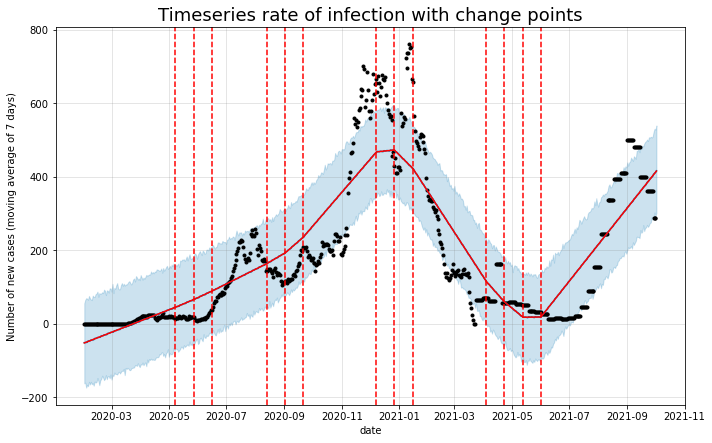

In [15]:
#We adjust our data to a format readable by FB Prophet library
daily_us_cases_OK_ma_7 = daily_us_cases_OK[['date','daily_cases_ma_7']].rename(columns={'date':'ds','daily_cases_ma_7':'y'})
m = Prophet()
m.fit(daily_us_cases_OK_ma_7)
#We don't really want to predict the future, so we only do 1 day
future = m.make_future_dataframe(periods=1)
forecast = m.predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
ax = fig.gca()
ax.set_title("Timeseries rate of infection with change points", size=18)
ax.set_xlabel("date")
ax.set_ylabel("Number of new cases (moving average of 7 days)")

We can observe clear change points occuring during the following dates:
    - June, 2020
    - September, 2020
    - January, 2021
    - May, 2021
    
It is very clear to note that when we cross this with the information we obtained from both the national and county levels, they match very well.

**National**
First Mask Mandate: April 2020
Mask Mandate is removed: January 2021
2nd Mask Mandate: 1 February 2021
2nd Mask Mandate is remove: June 10, 2021
Mask Mandate closed spaces is removed: February 25, 2022

1. We can see that when the first mask mandate was enforced (April, 2020 to January, 2021), the rate of growth (derivate) of the curve is less than the one period where mask mandates were removed (June 10,2021 to November, 2021), ceteris paribus, we can see that national mask enforcement of face masks appears to have reduced the rate of spread. 

2. The 2nd mask mandate (Feb, 2021 - Jun, 2021) shows a clear decrease in the rate of new casesaligned with the change points in the graph. 

3. When the 2nd mask mandate is removed (June 10,2021 to November, 2021) a very clear spike arrises.

Caveats: It is normal to observe a spike in cases during December given that:
    - In holidays people visit family and friends, incrreasing risk of infection
    - In holidays people fly to other places that require negative test proof, increasing the amount of tersts performed at this time of the year. We should ideally be able to normalize this effect with data of # of tests taken. 
    
**County**
First Mask Ordinance: August, 2020
Mask ordinance removed: December, 2020

1. As mentioned before in point 1 in the national level, rate of growth of new cases is much slower that that after June 10, 2021. 

This all gives us very good cause to think that people in Oklahoma followed the CDC recommendations to mask ("voluntarily masking") given that the dates where these recommendations were enforced, we observe improvements in number of new cases. 

Caveat: We are assuming in this case that wearing masks truly diminishes the rate of spread. 
    


### Vaccination

We obtain data from Bloomberg COVID vaccine tracker to find the coverage of vaccination in Oklahoma. We find the following:
- Jan 2021: First doses arrive
- Apr 2021: 50 doses per person
- Sept 2021: 100 doses per person
- Nov 2021: 120 doses per person

We can observe that there might be some association between vaccination and change point, it is clear that from January 2021 onwards there is a very strong decrease in new cases until May 2021. At this point, most of the people that desired to get a vaccine was covered, and vaccination plateaued, so this might also explain why after this date we do not keep seeing a decrease or stabilization of the curve, instead a increase of new cases. 

Caveat: This analysis is ceterisu paribus, not considering masking or anything else, and assuming that getting people vaccined progressively would lower the infection rate curve. 

## Step 2: Visualize
For Oklahoma, OK create a graph that visualizes how the course of the disease was changed by masking policies

As stated before, we do not have any masking policies in place according to our masking policy data, hence we show the complete trend of rate of infection and we save this plot in the results folder.

**The small code snippet to match the CDC dates with the plot was shared to me by Urmika**

19:47:36 - cmdstanpy - INFO - Chain [1] start processing
19:47:36 - cmdstanpy - INFO - Chain [1] done processing


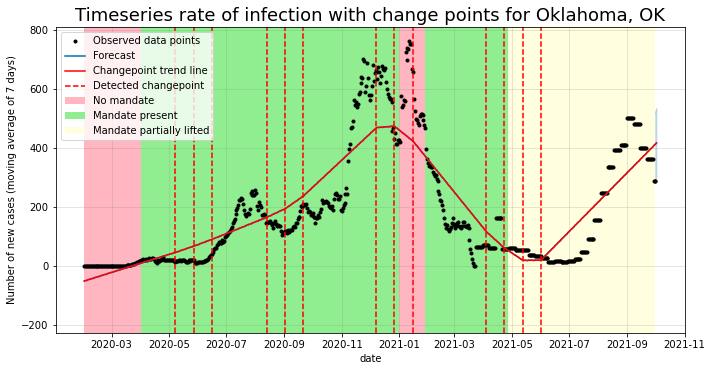

In [16]:
#We adjust our data to a format readable by FB Prophet library
daily_us_cases_OK_ma_7 = daily_us_cases_OK[['date','daily_cases_ma_7']].rename(columns={'date':'ds','daily_cases_ma_7':'y'})
m = Prophet()
m.fit(daily_us_cases_OK_ma_7)
#We don't really want to predict the future, so we only do 1 day
future = m.make_future_dataframe(periods=1)
forecast = m.predict(future)
fig, ax = plt.subplots(figsize=(10,5))
fig = m.plot(forecast, ax=ax)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
#We add the CDC masking data 
plt.axvspan('2020-02-01', '2020-04-09', facecolor='lightpink', label='No mandate')
plt.axvspan('2020-04-01','2021-01-01',facecolor='lightgreen', label= 'Mandate present')
plt.axvspan('2021-01-01', '2021-01-29', facecolor='lightpink')
plt.axvspan('2021-01-29', '2021-04-27', facecolor='lightgreen')
plt.axvspan('2021-04-27', '2021-10-01', facecolor='lightyellow', label= 'Mandate partially lifted')
# plt.axvspan('2022-02-25', '2022-10-01', facecolor='lightpink')
handles, labels = ax.get_legend_handles_labels()
handles = handles[:-1]
labels = labels[:-1]
line1 = plt.Line2D([0], [0], label='manual line', color='red')
line2 = plt.Line2D([0], [0], label='manual line', color='red', linestyle='--')
labels.extend(['Changepoint trend line', 'Detected changepoint'])
handles.extend([line1, line2])
order = [0,1,5,6,2,3,4]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
ax = fig.gca()
ax.set_title("Timeseries rate of infection with change points for Oklahoma, OK", size=18)
ax.set_xlabel("date")
ax.set_ylabel("Number of new cases (moving average of 7 days)")
plt.savefig('../results/timeseries_rate_of_infection_for_Oklahoma, OK.png',bbox_inches='tight')

This plot clearly includes the changes in the derivative function of the rate of infection through the change points and the red lines. The prophet API internally calculates the derivatives for these curves, finds the change points and plots them using the red lines. In the case of Oklahoma, OK, we observe that there are predominately 4 change points where the rate of infection derivative function changes. If we had data regarding masking enforcement, we would've added this information to the graph to understand and visualize if there is any trend. Given that we didn't, we used the CDC information we found before and added this to the plot to clearly visualize if there are any relationships between these CDC guidelines and Oklahoma, OK rate of infection.

The visualization was created using the Facebook Prophet library, it shows the timeseries rate of COVID infection from March 2020 to November 2021. This figure uses positive infection cases from the state of Oklahoma, OK that was originally in a cumulative form, this was later transformed to daily new cases feature and furthermore smoothed using a 7 window moving average, that help us remove weekly trends. This daily new cases data is shown in a timeseries to understand if there are any trends and moments where there are clear changes of rate of change. On the x axis we observe the date in chronological order and in the y axis we have # of new cases. The black dots are the observed data points, the red line represents the changepoint trend line, the vertical intermittent red lines represent detected changepoints and then the red, yellow, and green in the background represents the no mandate, mandate partially lifted and mandate present status in each point of time respectively. 

We use this plot to understand if there are any clear relationships between the trend changepoints and masking mandates. If there is, we would expect to observe that enforcing masking would affect the trend and we would view an identified changepoint. As an example, we can observe this occur in the plot between Jan 2021 and May 2021, where we observe that the start and end of having the mandate present is associated with the decreasing trend of new cases.


This was a very interesting characteristic of this assignment, especially because it's very rare to find that we are allowed to share code amongst ourselves. I started this assignment a little later than some of my colleagues, they started to chat through discord their solutions and they began sharing snippets that I decided to read and check out. When I started to do the analysis myself, I started to note that I was automatically replicating everything I saw in the discord, basically having no imagination or creativity around a different approach that I wanted to take. This began to make me note how strong the influence of other people's ideas can bias and blind us into not making the effort of creating our own, making us think that the solution we already saw is the only possibility. I feel that this is problematic given that in our current world, we are surrounded by the scientific method, which is basically founded by this same idea of sharing all creations and ideas to the rest of the world, so that "people can build from there and not reinvent the wheel" but, this could also be hindering our creativity, limiting us to only create based on others ideas or improving slightly upon another creation, but thinking outside the box can become increasingly more complicated.

On the other hand, I feel that this collaborative analysis in a 1:1 method did allow me to improve my work and my ideas. I discussed about my work with **Hriday** and **Urmika**. While we had this discussion, we stated to build from each other’s ideas, reaching better ideas each time, but not hindering or blocking our creativity or imagination, but instead, buttressing it and taking it to a next level, we would also find bad ideas that the other would point out and with good arguments we would eventually discard it. I feel that it is very interesting that the method in which there is an exchange of ideas, we can find hindering or improvement of our ideas. In my case, I discovered that working with big communities and reading everything that is out there, it will limit me as there is no participation, discussion, nor build=up. But when working with a select few, I feel that things change and with good discussion things can improve and creativity is not hindered. 

Specifically for my work, I took ideas both from my interaction with discord and through my 1:1 conversation.

## Part II & III & IV - Individual Analysis

Given that this is a separate analysis from Part 1, we will read all files again, we will create different intermediate data files that will be more suitable for this part of the analysis, we will be very thorough with the documentation to make sure they are not confused by labeling these new intermediate tables with "_part2" in the data_clean folder

## Step1: Reading files

### 1.1: Read COVID confirmed cases raw files

In [17]:
#We read the 3 input sources
raw_us_cases = pd.read_csv('../data_raw/RAW_us_confirmed_cases.csv')
mask_use = pd.read_csv('../data_raw/mask-use-by-county.csv')
mask_mandates = pd.read_csv('../data_raw/U.S._State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_August_15__2021_by_County_by_Day.csv')
#The US county to analyze is Oklahoma, Oklahoma, we want to find out what is the FIPS for this county
raw_us_cases[(raw_us_cases['Province_State']=='Oklahoma') & (raw_us_cases['Admin2']=='Oklahoma')]['FIPS']
#We find that Oklahoma County, Oklahoma's FIPS is 40109

2268    40109.0
Name: FIPS, dtype: float64

### 1.1: Read economy files

#### Unemployment Insurance Claims
Source: https://datausa.io/about/api/ 

In [18]:
#We read the data through the available API
response_API = requests.get('https://datausa.io/api/covid19/employment/latest/')
#We transform the data from source format to DataFrame (text -> JSON -> DataFrame)
data = response_API.text
parse_json = json.loads(data)
#We obtain a DataFrame that contains Unemployment data for all US
unemployment_usa = pd.json_normalize(parse_json, record_path =['data'])

#### Employment by Industry Sector
Source: https://api-ts-vibranium.datausa.io/tesseract/
This data has already been filtered for Oklahoma, OK in the requests URL

In [19]:
#We read the data through the available API
response_API = requests.get('https://api-ts-vibranium.datausa.io/tesseract/data.jsonrecords?cube=BLS Employment - Supersector Only&drilldowns=Month of Year,Supersector&measures=NSA Employees&State=04000US40')
#We transform the data from source format to DataFrame (text -> JSON -> DataFrame)
data = response_API.text
parse_json = json.loads(data)
#We obtain the desired DataFrame: employment_by_sector for Oklahoma, OK
employment_by_sector_OK = pd.json_normalize(parse_json, record_path =['data'])

## Step2: Data manipulation and cleaning

### 2.1: Filtering and unnecessary column removal

#### Clean *raw_us_cases* 
Source granularity: Daily

Desired levels of granularity: Weekly, Monthly

We would like to have a table with a date per row, so we filter for Oklahoma, OK and then we unpivot the table. We also want to filter such that it's between January 1, 2017 through October 1, 2021. For this table we retieve 1 year more (2017) given that we want to be able to match (inner join) with *employment_by sector* table

In [20]:
#We filter for Oklahoma, OK and then we unpivot the table
raw_us_cases_OK = raw_us_cases[(raw_us_cases['Province_State']=='Oklahoma') & (raw_us_cases['Admin2']=='Oklahoma')]
#We identify and remove unwanted columns
raw_us_cases_OK.drop(columns = ['UID','iso2','iso3','code3', 'Country_Region', 'Lat', 'Long_','Combined_Key','Province_State', 'Admin2','FIPS'],inplace=True)
us_cases_OK = pd.melt(raw_us_cases_OK,var_name='date',value_name='cases')
#We filter out the dates that are not between February 1, 2020 through October 1, 2021
us_cases_OK['date'] = pd.to_datetime(us_cases_OK['date'])
full_date_range = pd.DataFrame(pd.date_range("2017-01-01", "2021-10-01"), columns=['date'])
us_cases_OK = full_date_range.merge(us_cases_OK,on='date',how='left').fillna(0)
us_cases_OK = us_cases_OK[(us_cases_OK['date'] >= '2017-01-01') & (us_cases_OK['date'] <= '2021-10-01')]
us_cases_OK.reset_index(inplace=True, drop=True)

#### Clean *unemployment_usa* 
Source granularity: Weekly

We would like to have a table with a week date per row, so we filter for Oklahoma, OK. We also want to filter such that it's between January 1, 2018 through October 1, 2021. Additionaly, we want to know the week number

In [21]:
# We filter for Oklahoma, OK
unemployment_OK = unemployment_usa[unemployment_usa['fips_code'] == '04000US40']
unemployment_OK['year_week'] = pd.to_datetime(unemployment_OK['reflecting_week_end'])
#We filter out the dates that are not between February 1, 2020 through October 1, 2021
unemployment_OK = unemployment_OK[(unemployment_OK['year_week'] >= '2018-01-01') & (unemployment_OK['year_week'] <= '2021-10-01')]
#We obtain the year and week from the date
#unemployment_OK['year_week'] = unemployment_OK.reflecting_week_end.dt.strftime('%Y-w%U')
# We get rid of unnecesary columns
unemployment_OK.drop(columns=['fips_code','state_name','week_ended','reflecting_week_end'], inplace=True)
unemployment_OK.reset_index(inplace=True, drop=True)

#### Clean *employment_by_sector* 
Source granularity: Monthly

The source data is already filtered by Oklahoma, OK. We want to filter such that it's between January 1, 2017 through October 1, 2021. For this table we retieve 1 year more (2017) given that we will later calculate Year-over-Year data.

In [22]:
employment_by_sector_OK['year_month'] = pd.to_datetime(employment_by_sector_OK['Month of Year ID'])
#We filter out the dates that are not between February 1, 2020 through October 1, 2021
employment_by_sector_OK = employment_by_sector_OK[(employment_by_sector_OK['year_month'] >= '2017-01-01') & (employment_by_sector_OK['year_month'] <= '2021-10-01')]
# We get rid of unnecesary columns
employment_by_sector_OK.drop(columns=['Month of Year ID', 'Month of Year','Supersector ID'], inplace=True)
employment_by_sector_OK.reset_index(inplace=True, drop=True)

### Save processed files into the *data_clean* folder

In [23]:
us_cases_OK.to_csv('../data_clean/us_cases_OK_part_2.csv')
unemployment_OK.to_csv('../data_clean/unemployment_OK_part_2.csv')
employment_by_sector_OK.to_csv('../data_clean/employment_by_sector_OK_part_2.csv')


### 2.2: Prepare for time series analysis
We currently have cummulative cases, given that we want to analyze the time series, it is more convenient to convert this into daily new cases.

In [24]:
us_cases_OK['daily_cases'] = us_cases_OK['cases'] - us_cases_OK.shift(periods=1)['cases']
daily_us_cases_OK = us_cases_OK.fillna(0)

### 2.3: Matching table granularities
We know that the unemployment data has a weekly granularity and that the employment_by_sector data has a monthly granularity. Our inicial data (COVID cases) has a daily granularity. 

We will perform the necessary aggregations to have the COVID cases data at a weekly and monthly granularity by summing cases throughout the week and month respectively. 


In [25]:
#We want to create helper columns that contain the monthly and weekly date formats
daily_us_cases_OK['year_week'] = daily_us_cases_OK.date.dt.strftime('%Y-w%U')
daily_us_cases_OK['year_month'] = daily_us_cases_OK.date.dt.strftime('%Y-%m')
#We aggregate the data into two new DataFrames, one per each desired granularity
us_monthly_cases_OK = daily_us_cases_OK[['year_month','daily_cases']].groupby('year_month').sum()
us_monthly_cases_OK.reset_index(inplace=True)
us_weekly_cases_OK = daily_us_cases_OK[['year_week','daily_cases']].groupby('year_week').sum()
us_weekly_cases_OK.reset_index(inplace=True)

We convert the time columns to datetime

In [26]:
us_monthly_cases_OK['year_month']= pd.to_datetime(us_monthly_cases_OK['year_month'])
us_weekly_cases_OK['year_week']= pd.to_datetime(us_weekly_cases_OK['year_week']+ '6', format = '%Y-w%U%w')

### 2.4: Joining tables
We want to understand the association between cases and economic data, so we will join the tables by date according to their granularities, these will be our pre-processing final output. 


In [27]:
#Joining unemployment_OK , granularity: weekly
unemployment_OK_cases = unemployment_OK.merge(us_weekly_cases_OK,on = 'year_week')
#We remove unwanted columns 
unemployment_OK_cases.drop(columns=['continued_claims', 'covered_employment','insured_unemployment_rate'], inplace=True)

unemployment_OK_cases.to_csv('../data_clean/unemployment_OK_cases_part_2.csv', index=False)
#Joining employment_by_sector, granularity: monthly
employment_by_sector_OK_cases = employment_by_sector_OK.merge(us_monthly_cases_OK, on='year_month')
employment_by_sector_OK_cases.to_csv('../data_clean/employment_by_sector_OK_cases_part_2.csv', index=False)

#### *unemployment_OK_cases* 
Granularity: Weekly

Weekly Unemployment data with weekly confirmed COVID cases merged week-by-week for Oklahoma County.

In [28]:
unemployment_OK_cases

,initial_claims,year_week,daily_cases
0,2253,2021-08-21,2753.0
1,3146,2021-08-14,2350.0
2,3986,2021-08-07,1715.0
3,3838,2021-07-31,1085.0
4,3533,2021-07-24,624.0
...,...,...,...
189,1590,2018-01-27,0.0
190,1563,2018-01-20,0.0
191,1472,2018-01-13,0.0
192,1838,2018-01-06,0.0


#### *employment_by_sector_OK_cases* 
Granularity: Monthly

Monthly employment data with monthly confirmed COVID cases merged month-by-month for Oklahoma County.

In [29]:
employment_by_sector_OK_cases

,Supersector,NSA Employees,year_month,daily_cases
0,"Mining, Logging, and Construction",7105700.0,2017-01-01,0.0
1,Manufacturing,12373400.0,2017-01-01,0.0
2,"Trade, Transportation, and Utilities",27341400.0,2017-01-01,0.0
3,Information,2814700.0,2017-01-01,0.0
4,Financial Activities,8303400.0,2017-01-01,0.0
...,...,...,...,...
525,Professional and Business Services,20975300.0,2021-05-01,1216.0
526,Education and Health Services,23592300.0,2021-05-01,1216.0
527,Leisure and Hospitality,13867900.0,2021-05-01,1216.0
528,Other Services,5307200.0,2021-05-01,1216.0


## Step 3: Visualizations

### 3.0: Read clean data 

*unemployment_OK_cases*: Weekly unemployment insurance claims merged with weekly sum of COVID cases in Oklahoma, OK

In [30]:
unemployment_OK_cases = pd.read_csv('../data_clean/unemployment_OK_cases_part_2.csv')

*employment_by_sector_OK*: Monthly employment by industry sector merged with monthly sum of COVID cases in Oklahoma, OK

In [31]:
employment_by_sector_OK_cases = pd.read_csv('../data_clean/employment_by_sector_OK_cases_part_2.csv')

### 3.1: **Plot #1:** Weekly unemployment insurance claims visualization

Text(0.5, 1.0, 'Line plot of confirmed COVID cases vs. unemployment insurance claims (weekly)')

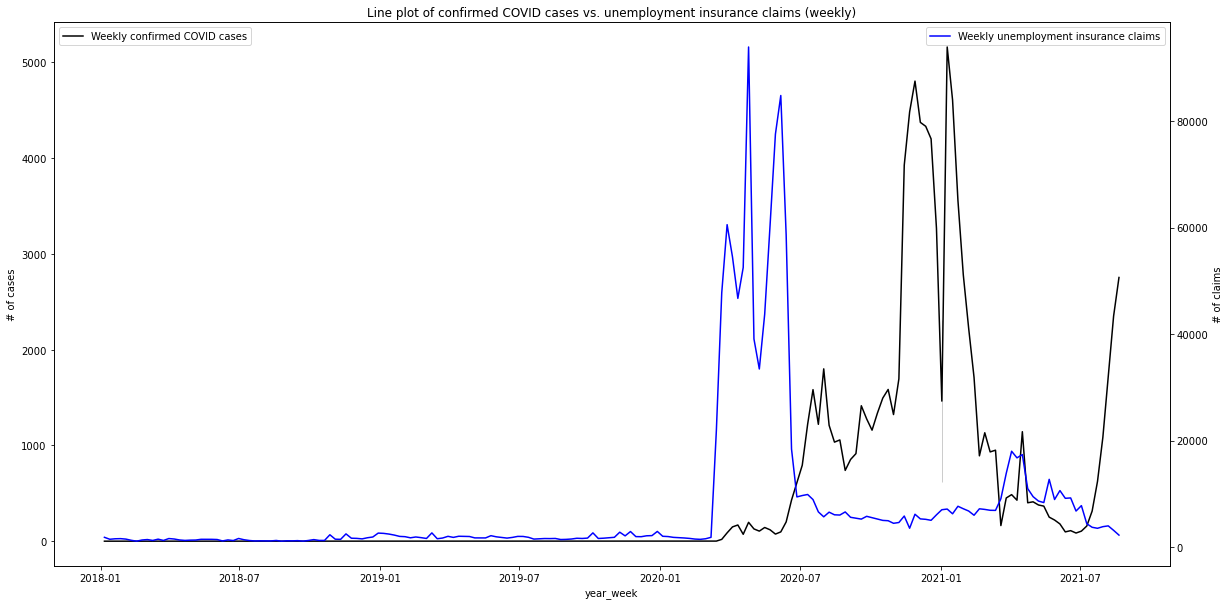

In [32]:
plt.figure(figsize=(20,10))
unemployment_OK_cases['year_week']=pd.to_datetime(unemployment_OK_cases['year_week'])
ax1 = sns.lineplot(x="year_week", y="daily_cases" , color="black",data=unemployment_OK_cases, legend=False)
ax1.legend(['Weekly confirmed COVID cases'], loc="upper left")
ax1.set_ylabel('# of cases')
ax2 = plt.twinx()
sns.lineplot(x="year_week", y="initial_claims", color="b", ax=ax2,data=unemployment_OK_cases, legend = False)
ax2.legend(['Weekly unemployment insurance claims'], loc="upper right")
ax2.set_ylabel('# of claims')
ax2.set_title("Line plot of confirmed COVID cases vs. unemployment insurance claims (weekly)")

We would like to also plot YoY percentage change for the number of unemployment insurance claims to make sure there is no seasonality effect in our comparison. Given that the post-pandemic data is more than 1 year long, we want to make sure not to compare post-pandemic data with post-pandemic data, hence, we will compare always with regards to the first pre-pandemic year.

### 3.2: **Plot #2:** Weekly unemployment claims with YoY visualization 


In [33]:
#We find the first week day with confirmed COVID cases in Oklahoma, OK
unemployment_OK_cases.sort_values('year_week',inplace=True)
unemployment_OK_cases = unemployment_OK_cases.reset_index(drop=True)
first_COVID_OK = unemployment_OK_cases.daily_cases.ne(0).idxmax()
day_first_COVID_OK = unemployment_OK_cases.loc[first_COVID_OK].year_week
day_first_COVID_OK_anniversary = unemployment_OK_cases.loc[first_COVID_OK+51].year_week
#We filter 
#post_pandemic_weekly_unemployment_growth = unemployment_OK_cases[unemployment_OK_cases['year_week']>=day_first_COVID_OK]
#We calculate the YoY percentage change
unemployment_OK_cases['Weekly growth (YoY) 1 year']=  unemployment_OK_cases['initial_claims'].pct_change(52)
#We calculate the YoY percentage change for 2 years difference
unemployment_OK_cases['Weekly growth (YoY) 2 year']=  unemployment_OK_cases['initial_claims'].pct_change(104)
#We join these two such that we create a column that only compares with the first pre-pandemic year
unemployment_OK_cases['Weekly growth (YoY)'] = np.where(unemployment_OK_cases['year_week']>day_first_COVID_OK_anniversary , unemployment_OK_cases['Weekly growth (YoY) 2 year'], unemployment_OK_cases['Weekly growth (YoY) 1 year'])

Text(0.5, 1.0, 'Line plot of confirmed COVID cases vs. unemployment insurance claims YoY growth (weekly)')

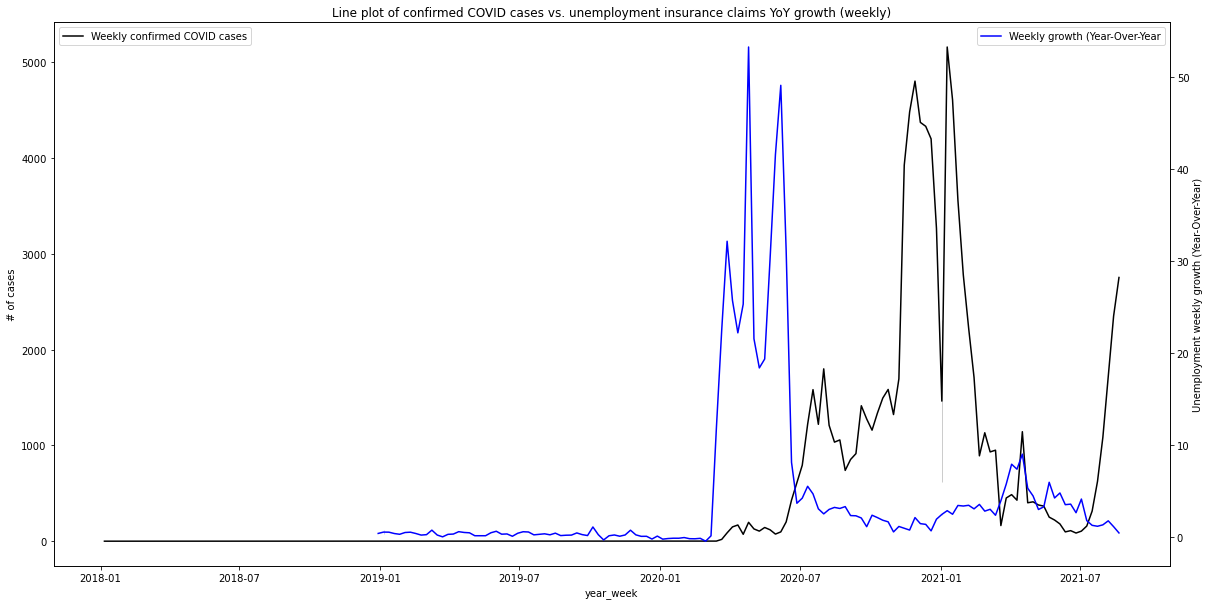

In [34]:
plt.figure(figsize=(20,10))
ax1 = sns.lineplot(x="year_week", y="daily_cases" , color="black",data=unemployment_OK_cases, legend=False)
ax1.legend(['Weekly confirmed COVID cases'], loc="upper left")
ax1.set_ylabel('# of cases')
ax2 = plt.twinx()
sns.lineplot(x="year_week", y="Weekly growth (YoY)", color="b", ax=ax2,data=unemployment_OK_cases, legend = False)
ax2.legend(['Weekly growth (Year-Over-Year'], loc="upper right")
ax2.set_ylabel('Unemployment weekly growth (Year-Over-Year)')
ax2.set_title("Line plot of confirmed COVID cases vs. unemployment insurance claims YoY growth (weekly)")

We observe that in the beggining of the pandemic the YoY growth sky-rocketted, but after the week of the 27 of June we observe that YoY growth stabilizes between 300 and 800 percent but never goes back to the pre-pandemic +-70 percent 

### 3.3: **Plot #3** Monthly employment by sector visualization

Text(0.5, 1.0, 'Line plot of confirmed COVID cases vs. employment by sector (monthly)')

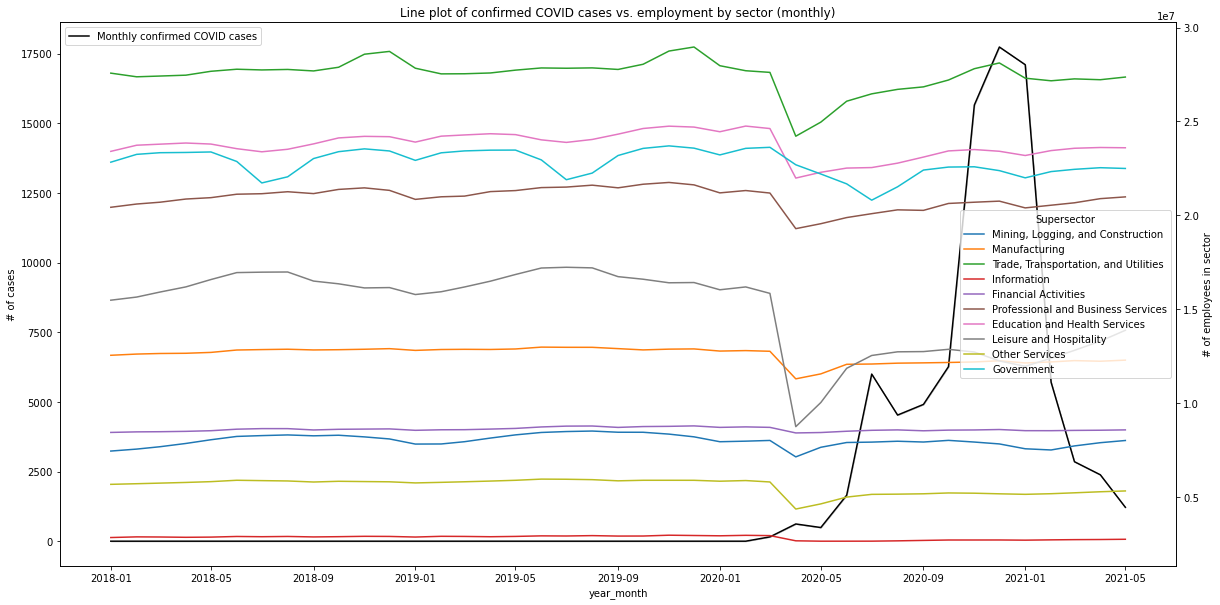

In [35]:
plt.figure(figsize=(20,10))
employment_by_sector_OK_cases['year_month']=pd.to_datetime(employment_by_sector_OK_cases['year_month'])
employment_by_sector_OK_cases_temp = employment_by_sector_OK_cases[(employment_by_sector_OK_cases['year_month'] >= '2018-01-01') & (employment_by_sector_OK_cases['year_month'] <= '2021-10-01')]
ax1 = sns.lineplot(x="year_month", y="daily_cases" , color="black",data=employment_by_sector_OK_cases_temp, legend=False)
ax1.legend(['Monthly confirmed COVID cases'], loc="upper left")
ax1.set_ylabel('# of cases')
ax2 = plt.twinx()
sns.lineplot(x="year_month", y="NSA Employees", hue='Supersector', color="b", ax=ax2,data=employment_by_sector_OK_cases_temp)
ax2.set_ylabel('# of employees in sector')
ax1.set_title("Line plot of confirmed COVID cases vs. employment by sector (monthly)")

We observe in the previous plot that (naturally) different sectors have different amount of employees. It is interesting to see how government appears to have layoffs much later, but we can onbserve that there is a seasonal trend of layoffs between June and September. We would like to have a better metric to be able to compare across sectors in a apples-to-apples fashion. Given that employment is seasonal according to many economists, many researchers tend to transform this metric to a Year-over-Year metric as follows:

Monthly growth (Year-over-Year) = ("NSA Employees"_t - "NSA Employees"_t-12)/"NSA Employees"_t-12

Given that the post-pandemic data is more than 1 year long, we want to make sure not to compare post-pandemic data with post-pandemic data, hence, we will compare always with regards to the first pre-pandemic year.

In [36]:
#We calculate the YoY percentage change
employment_by_sector_OK_cases = employment_by_sector_OK_cases.sort_values(['Supersector','year_month'])
employment_by_sector_OK_cases['Monthly growth (YoY) 1 year']= employment_by_sector_OK_cases['NSA Employees'].pct_change(12)
#We calculate the YoY percentage change for 2 years difference
employment_by_sector_OK_cases['Monthly growth (YoY) 2 year']= employment_by_sector_OK_cases['NSA Employees'].pct_change(24)
day_first_COVID_OK_anniversary_month = unemployment_OK_cases.loc[first_COVID_OK+52].year_week
#We join these two such that we create a column that only compares with the first pre-pandemic year
employment_by_sector_OK_cases['Monthly growth (YoY)'] = np.where(employment_by_sector_OK_cases['year_month']>day_first_COVID_OK_anniversary_month, employment_by_sector_OK_cases['Monthly growth (YoY) 2 year'], employment_by_sector_OK_cases['Monthly growth (YoY) 1 year'])
#employment_by_sector_OK_cases = employment_by_sector_OK_cases[(employment_by_sector_OK_cases['year_month'] >= '2018-01-01') & (employment_by_sector_OK_cases['year_month'] <= '2021-10-01')]





### 3.4: **Plot #4:** Monthly employment by sector with YoY visualization 

Text(0.5, 1.0, 'Line plot of confirmed COVID cases vs. employment by sector YoY growth (monthly)')

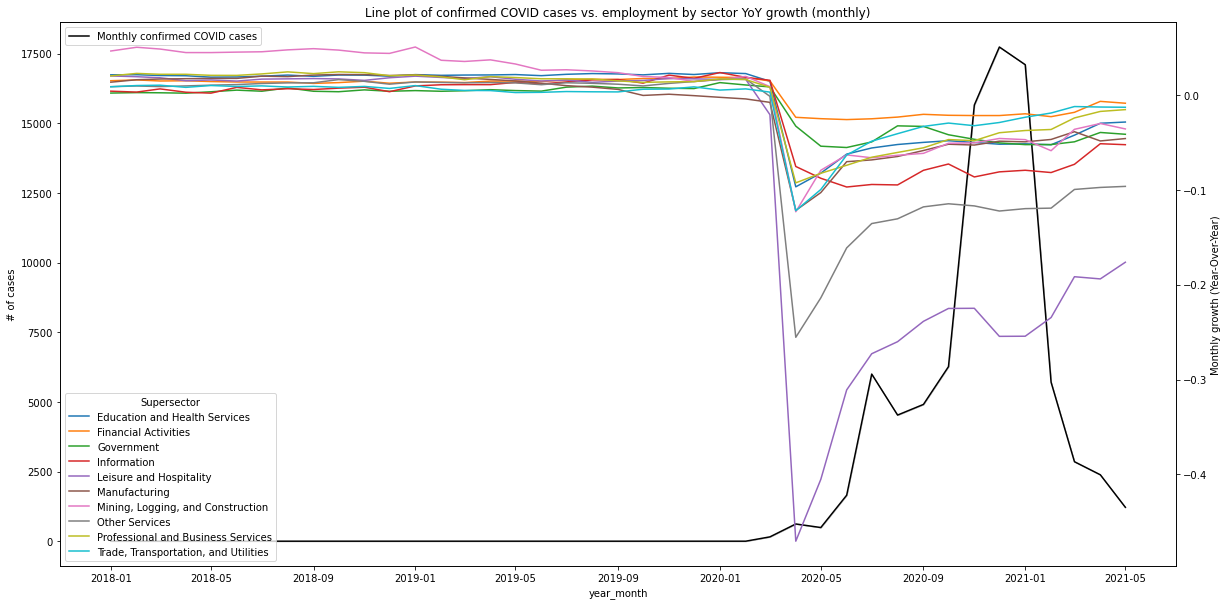

In [37]:
plt.figure(figsize=(20,10))
employment_by_sector_OK_cases['year_month']=pd.to_datetime(employment_by_sector_OK_cases['year_month'])
employment_by_sector_OK_cases_temp = employment_by_sector_OK_cases[(employment_by_sector_OK_cases['year_month'] >= '2018-01-01') & (employment_by_sector_OK_cases['year_month'] <= '2021-10-01')]
ax1 = sns.lineplot(x="year_month", y="daily_cases" , color="black",data=employment_by_sector_OK_cases_temp, legend=False)
ax1.legend(['Monthly confirmed COVID cases'], loc="upper left")
ax1.set_ylabel('# of cases')
ax2 = plt.twinx()
sns.lineplot(x="year_month", y="Monthly growth (YoY)", hue='Supersector', color="b", ax=ax2,data=employment_by_sector_OK_cases_temp)
#ax2.legend(['Monthly current employees in sector'], loc="upper right")
ax2.set_ylabel('Monthly growth (Year-Over-Year)')
ax1.set_title("Line plot of confirmed COVID cases vs. employment by sector YoY growth (monthly)") 

## Step 4: Statistical analysis

We would like to answer the following:
Research question: What effect on employment did the pandemic generate inside Oklahoma county? 

Hypothesis: I expect to see multiple effects between employment and the pandemic, specifically I consider:
1.	The highest peak of unemployment occurred right at the beginning of the pandemic; this initial peak can be up to 30x the average rate of unemployment for the previous year before the pandemic.
2.	The industry sectors that got the heaviest unemployment rates were leisure & hospitality as well as other heavy blue collar job industries. 
3.	Is working in Finance or Government sectors a safer bet when facing pandemic layoff?
4.	After 1 year of pandemic, all sectors have been able to recuperate at least 80% of their layoffs.


### 4.1: Hypothesis #1: The highest peak of unemployment occurred right at the beginning of the pandemic; this initial peak can be up to 30x the average rate of unemployment for the previous year before the pandemic. 

#### 4.1.1 Plot (visual) analysis

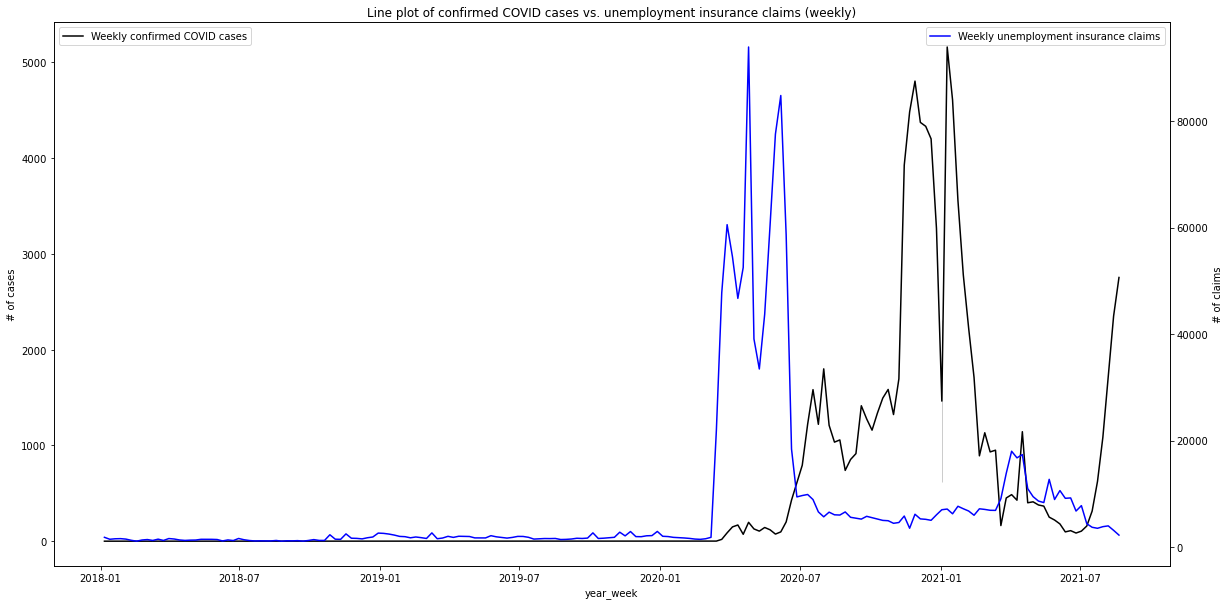

In [38]:
plt.figure(figsize=(20,10))
unemployment_OK_cases['year_week']=pd.to_datetime(unemployment_OK_cases['year_week'])
ax1 = sns.lineplot(x="year_week", y="daily_cases" , color="black",data=unemployment_OK_cases, legend=False)
ax1.legend(['Weekly confirmed COVID cases'], loc="upper left")
ax1.set_ylabel('# of cases')
ax2 = plt.twinx()
sns.lineplot(x="year_week", y="initial_claims", color="b", ax=ax2,data=unemployment_OK_cases, legend = False)
ax2.legend(['Weekly unemployment insurance claims'], loc="upper right")
ax2.set_ylabel('# of claims')
ax2.set_title("Line plot of confirmed COVID cases vs. unemployment insurance claims (weekly)")
plt.savefig('../results/Line plot of confirmed COVID cases vs. unemployment insurance claims (weekly).png',bbox_inches='tight')


In the previous plot we can observe that it is true that the COVID pandemic highly affected the # of unemployment insurance claims. We can observe that in the moment that the pandemic starts and we observe the first cases arise in the county there is a big jump in unemployment. We would like to know if there was a lag between the start of the pandemic and the start of unemployment claims? If so, by how much?

#### 4.1.2 Lag between start of pandemic and unemployment claims

In [39]:
#We find the first week day with confirmed COVID cases in Oklahoma, OK
unemployment_OK_cases.sort_values('year_week',inplace=True)
unemployment_OK_cases = unemployment_OK_cases.reset_index(drop=True)
first_COVID_OK = unemployment_OK_cases.daily_cases.ne(0).idxmax()
day_first_COVID_OK = unemployment_OK_cases.loc[first_COVID_OK].year_week
#We find the week day of the first agressive peak change in # of unemployment claims 
unemployment_OK_cases['weekly_claim_growth']= unemployment_OK_cases['initial_claims'].pct_change()
first_unemployment_peak_OK = unemployment_OK_cases.weekly_claim_growth.idxmax()
day_first_unemployment_peak = unemployment_OK_cases.loc[first_unemployment_peak_OK].year_week
#We check if the first week with confirmed cases of COVID is the same week with the highest change in unemployment claims
first_COVID_OK==first_unemployment_peak_OK

True

In [61]:
#We check which were the top 5 days with highest growth change for initial unemployment claims
top_growth = unemployment_OK_cases.weekly_claim_growth.sort_values(ascending=False).head(5)
unemployment_OK_cases.loc[top_growth.index][['year_week','initial_claims','daily_cases','weekly_claim_growth']].round(decimals=2)

,year_week,initial_claims,daily_cases,weekly_claim_growth
117,2020-03-14,21926,1.0,10.94
118,2020-03-21,47744,19.0,1.18
43,2018-10-27,2317,0.0,0.85
123,2020-04-25,93885,197.0,0.79
154,2020-11-28,6168,4803.0,0.74


We have discovered that the first week with confirmed cases of COVID is the same week with the highest change in unemployment claims

#### 4.1.3 Percentage change between highest 3 unemployment peaks and the average unemployment claims

In [41]:
#We calculate the number and dates of the 3 highest peaks of unemployment claims
top_unemployment_peak = unemployment_OK_cases.initial_claims.sort_values(ascending=False).head(5)
top_unemployment_peak = unemployment_OK_cases.loc[top_unemployment_peak.index]
#We know that the 3 unemployment peaks found in the plot are 2020-03-28, 2020-04-25 and 2020-06-06 
unemployment_peak = unemployment_OK_cases.loc[[123,129,119]]
#We calculate the average unemployment claim of 1 year (52 weeks) previous to COVID start week (2020-03-14)
mean_unemployment_claims_pre_covid = unemployment_OK_cases[first_COVID_OK-52 : first_COVID_OK].initial_claims.mean()
mean_unemployment_claims_pre_covid

1869.673076923077

In [60]:
#We calculate the percentage change for each of the peaks
peak_change = unemployment_peak.copy()
peak_change['percentage_change_from_pre_covid_mean'] = peak_change.initial_claims.apply(lambda x: (x-mean_unemployment_claims_pre_covid)*100/mean_unemployment_claims_pre_covid)
peak_change['number_times_from_pre_covid_mean'] = peak_change.initial_claims.apply(lambda x: (x/mean_unemployment_claims_pre_covid))
peak_change[['year_week','initial_claims','percentage_change_from_pre_covid_mean','number_times_from_pre_covid_mean']].round(decimals=2)                                                                         

,year_week,initial_claims,percentage_change_from_pre_covid_mean,number_times_from_pre_covid_mean
123,2020-04-25,93885,4921.47,50.21
129,2020-06-06,84779,4434.43,45.34
119,2020-03-28,60534,3137.68,32.38


#### 4.1.4 Confidence interval of the YoY weekly growth of pre vs. post pandemic unemployment claims.

In [43]:
#We get the post-pandemic weekly unemployment growth (YoY)
post_pandemic_weekly_unemployment_growth = unemployment_OK_cases[unemployment_OK_cases['year_week']>=day_first_COVID_OK]['Weekly growth (YoY)']
#Assuming normality in our sample data, we calculate a 95 CI
stats.norm.interval(alpha=0.95, loc=np.mean(post_pandemic_weekly_unemployment_growth), scale=stats.sem(post_pandemic_weekly_unemployment_growth))

(5.29333828846757, 10.331769700112485)

Assuming normality, we have that the mean YoY weekly growth of unemployment claims has a confidence interval between 374 and 905 percent

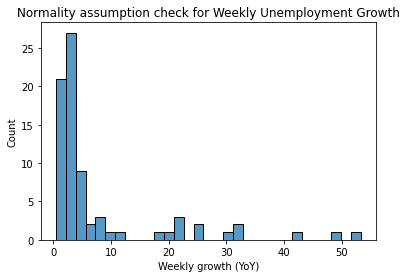

In [44]:
#We check for normality
sns.histplot(post_pandemic_weekly_unemployment_growth).set(title='Normality assumption check for Weekly Unemployment Growth')
plt.savefig('../results/Normality assumption check for Weekly Unemployment Growth.png',bbox_inches='tight')

We observe that the data doesn't follow a normal distribution, so we rather not display these results 

#### 4.1.5 Box plot of the YoY weekly growth of pre vs. post pandemic unemployment claims.

[Text(0.5, 1.0, 'Pre vs. post pandemic YoY weekly growth of unemployment claims.')]

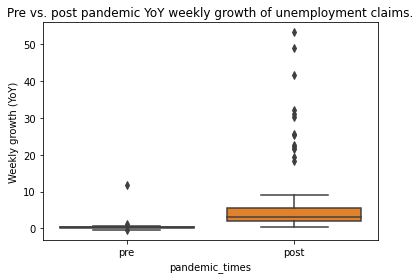

In [45]:
unemployment_OK_cases['pandemic_times'] = np.where(unemployment_OK_cases['year_week']>day_first_COVID_OK , "post", "pre")
sns.boxplot(data=unemployment_OK_cases,x='pandemic_times',y='Weekly growth (YoY)').set(title='Pre vs. post pandemic YoY weekly growth of unemployment claims.')


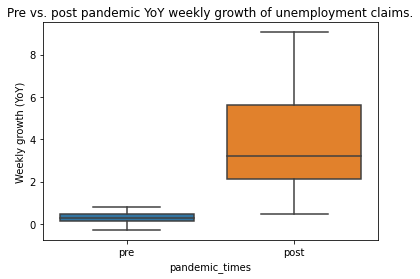

In [46]:
#We remove the outliers from the boxplot
sns.boxplot(data=unemployment_OK_cases,x='pandemic_times',y='Weekly growth (YoY)', showfliers=False).set(title='Pre vs. post pandemic YoY weekly growth of unemployment claims.')
plt.savefig('../results/Box Plot: Pre vs. post pandemic YoY weekly growth of unemployment claims.png',bbox_inches='tight')


We know that between the 14 of March and the 27 of June, there were big peaks with a lot of volatility, we want to observe the post-normality as well

[Text(0.5, 1.0, 'Pre vs. post YoY weekly growth of pandemic unemployment claims')]

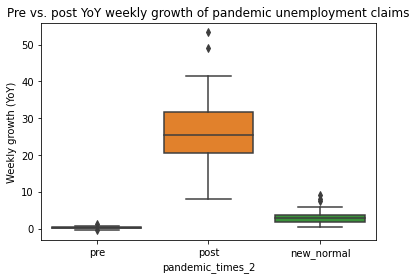

In [47]:
unemployment_OK_cases['pandemic_times_2'] = np.where(unemployment_OK_cases['year_week']<day_first_COVID_OK , "pre", np.where(unemployment_OK_cases['year_week']<'2020-06-27', "post","new_normal"))
sns.boxplot(data=unemployment_OK_cases,x='pandemic_times_2',y='Weekly growth (YoY)').set(title='Pre vs. post vs. new-normal YoY weekly growth of pandemic unemployment claims')


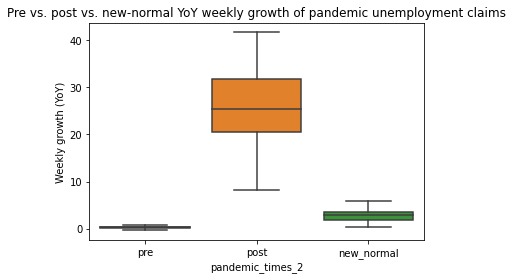

In [48]:
#We remove the outliers from the boxplot
sns.boxplot(data=unemployment_OK_cases,x='pandemic_times_2',y='Weekly growth (YoY)', showfliers=False).set(title='Pre vs. post vs. new-normal YoY weekly growth of pandemic unemployment claims')
plt.savefig('../results/Box Plot: Pre vs. post vs. new-normal YoY weekly growth of pandemic unemployment claims.png',bbox_inches='tight')


### 4.2: Hypothesis #2: The industry sectors that got the heaviest unemployment rates were leisure & hospitality as well as other heavy blue collar job industries.

#### 4.2.1 Plot (visual) analysis

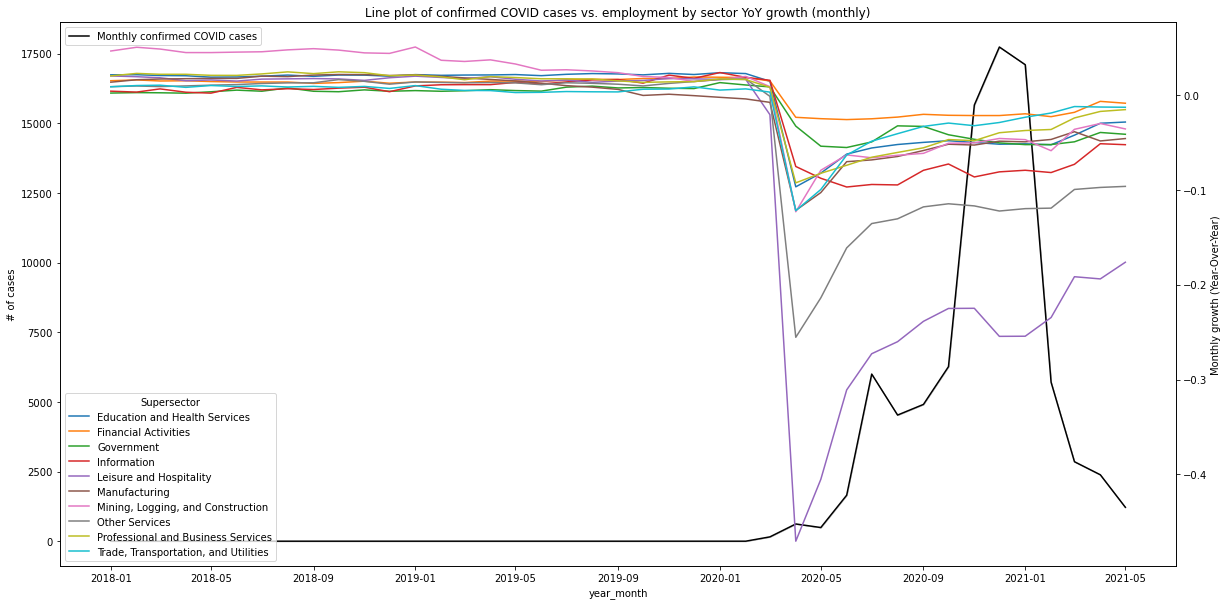

In [49]:
plt.figure(figsize=(20,10))
employment_by_sector_OK_cases['year_month']=pd.to_datetime(employment_by_sector_OK_cases['year_month'])
employment_by_sector_OK_cases_temp = employment_by_sector_OK_cases[(employment_by_sector_OK_cases['year_month'] >= '2018-01-01') & (employment_by_sector_OK_cases['year_month'] <= '2021-10-01')]
ax1 = sns.lineplot(x="year_month", y="daily_cases" , color="black",data=employment_by_sector_OK_cases_temp, legend=False)
ax1.legend(['Monthly confirmed COVID cases'], loc="upper left")
ax1.set_ylabel('# of cases')
ax2 = plt.twinx()
sns.lineplot(x="year_month", y="Monthly growth (YoY)", hue='Supersector', color="b", ax=ax2,data=employment_by_sector_OK_cases_temp)
#ax2.legend(['Monthly current employees in sector'], loc="upper right")
ax2.set_ylabel('Monthly growth (Year-Over-Year)')
ax1.set_title("Line plot of confirmed COVID cases vs. employment by sector YoY growth (monthly)") 
plt.savefig('../results/Line plot of confirmed COVID cases vs. employment by sector YoY growth (monthly).png',bbox_inches='tight')


We can observe that the industry sectors that got the heaviest unemployment rates were leisure & hospitality as well as other heavy blue collar job industries. We want to dive deeper so we create box-plots for post-pandemic Monthly growth (YoY)

#### 4.2.2 Box-plot accross industry sectors to have a better separation

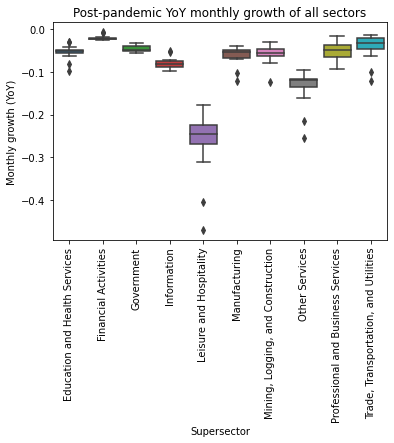

In [50]:
box_by_sector = sns.boxplot(data=employment_by_sector_OK_cases[employment_by_sector_OK_cases['year_month']>day_first_COVID_OK],x='Supersector',y='Monthly growth (YoY)')
box_by_sector.tick_params(axis='x', labelrotation = 90)
box_by_sector.set(title='Post-pandemic YoY monthly growth of all sectors')
plt.savefig('../results/Box plot: Post-pandemic YoY monthly growth of all sectors Post-pandemic YoY monthly growth of all sectors.png',bbox_inches='tight')


[Text(0.5, 1.0, 'Post-pandemic YoY monthly growth of all sectors ')]

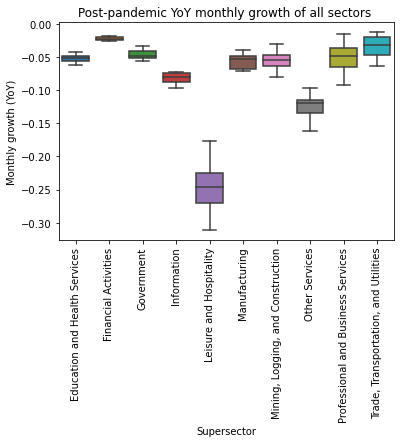

In [51]:
box_by_sector_woo = sns.boxplot(data=employment_by_sector_OK_cases[employment_by_sector_OK_cases['year_month']>day_first_COVID_OK],x='Supersector',y='Monthly growth (YoY)', showfliers=False)
box_by_sector_woo.tick_params(axis='x', labelrotation = 90)
box_by_sector_woo.set(title='Post-pandemic YoY monthly growth of all sectors ')

In the above plot, it is clear that when COVID cases start to appear in Oklahoma, OK, all industry sectors suffer a very strong loss of employment. We can also visually observe that some sectors were more hardly hit than others. Sectors such as Leisure and Hospitality, Other Services, were specially hit while other sectors such as Financial Activity and Government were the ones that suffered less. We want to observe this better using box plots by sector.

We can conclude that the industry sectors with heaviest uenmployment rates were Leisure & Hospitality and other blue collar jobs such as "Other Services" and "Manufacturing". But what about the other side of the coin? Which are the sectors that were less hit and could be considered "safer"? 




### 4.3: Hypothesis #3: Is working in Finance or Government sectors a safer bet when facing pandemic layoff? 

#### 4.3.1 One-way ANOVA multiple mean test (F-test) to check if there is statistical difference between sectors

In [52]:

stats.f_oneway(employment_by_sector_OK_cases[(employment_by_sector_OK_cases['Supersector']=='Education and Health Services') & (employment_by_sector_OK_cases['year_month']>day_first_COVID_OK)]['Monthly growth (YoY)'],
              employment_by_sector_OK_cases[(employment_by_sector_OK_cases['Supersector']=='Financial Activities')& (employment_by_sector_OK_cases['year_month']>day_first_COVID_OK)]['Monthly growth (YoY)'],
              employment_by_sector_OK_cases[(employment_by_sector_OK_cases['Supersector']=='Government')& (employment_by_sector_OK_cases['year_month']>day_first_COVID_OK)]['Monthly growth (YoY)'],
              employment_by_sector_OK_cases[(employment_by_sector_OK_cases['Supersector']=='Information')& (employment_by_sector_OK_cases['year_month']>day_first_COVID_OK)]['Monthly growth (YoY)'],
              employment_by_sector_OK_cases[(employment_by_sector_OK_cases['Supersector']=='Leisure and Hospitality')& (employment_by_sector_OK_cases['year_month']>day_first_COVID_OK)]['Monthly growth (YoY)'],
              employment_by_sector_OK_cases[(employment_by_sector_OK_cases['Supersector']=='Manufacturing')& (employment_by_sector_OK_cases['year_month']>day_first_COVID_OK)]['Monthly growth (YoY)'],
              employment_by_sector_OK_cases[(employment_by_sector_OK_cases['Supersector']=='Mining, Logging, and Construction')& (employment_by_sector_OK_cases['year_month']>day_first_COVID_OK)]['Monthly growth (YoY)'],
              employment_by_sector_OK_cases[(employment_by_sector_OK_cases['Supersector']=='Other Services')& (employment_by_sector_OK_cases['year_month']>day_first_COVID_OK)]['Monthly growth (YoY)'],
              employment_by_sector_OK_cases[(employment_by_sector_OK_cases['Supersector']=='Professional and Business Services')& (employment_by_sector_OK_cases['year_month']>day_first_COVID_OK)]['Monthly growth (YoY)'],
              employment_by_sector_OK_cases[(employment_by_sector_OK_cases['Supersector']=='Trade, Transportation, and Utilities')& (employment_by_sector_OK_cases['year_month']>day_first_COVID_OK)]['Monthly growth (YoY)'])

F_onewayResult(statistic=58.95877089886192, pvalue=1.2964906766364846e-41)

With 99% confidence we reject the null hypothesis (all means are equal), hence, at least one of these groups have a different population mean

#### 4.3.2 Multiple t-test between Finance or Government sectors and the rest of sectors

In [63]:
from itertools import combinations
...

def ttest_run(c1, c2):
    results = stats.ttest_ind(employment_by_sector_OK_cases[(employment_by_sector_OK_cases['Supersector']==c1)& (employment_by_sector_OK_cases['year_month']>day_first_COVID_OK)]['Monthly growth (YoY)'], 
                              employment_by_sector_OK_cases[(employment_by_sector_OK_cases['Supersector']==c2)& (employment_by_sector_OK_cases['year_month']>day_first_COVID_OK)]['Monthly growth (YoY)'])
    df = pd.DataFrame({'categ1': c1,
                       'categ2': c2,
                       'tstat': results.statistic,
                       'pvalue': results.pvalue}, 
                       index = [0])    
    return df

df_list = [ttest_run(i, j) for i, j in combinations(employment_by_sector_OK_cases['Supersector'].unique().tolist(), 2)]

final_df = pd.concat(df_list, ignore_index = True)

results = final_df[final_df['categ1'].isin(['Financial Activities','Government'])| final_df['categ2'].isin(['Financial Activities','Government'])]
results['p_value_correction'] = multipletests(results.pvalue, alpha =0.05, method = 'bonferroni')[1]
results['reject_correction'] = multipletests(results.pvalue, alpha =0.05, method = 'bonferroni')[0]
results.round(decimals=4)



,categ1,categ2,tstat,pvalue,p_value_correction,reject_correction
0,Education and Health Services,Financial Activities,-6.6829,0.0000,0.0000,True
1,Education and Health Services,Government,-1.6718,0.1066,1.0000,False
9,Financial Activities,Government,9.2925,0.0000,0.0000,True
10,Financial Activities,Information,14.6114,0.0000,0.0000,True
11,Financial Activities,Leisure and Hospitality,11.1491,0.0000,0.0000,True
12,Financial Activities,Manufacturing,6.5003,0.0000,0.0000,True
13,Financial Activities,"Mining, Logging, and Construction",5.9150,0.0000,0.0001,True
14,Financial Activities,Other Services,9.3633,0.0000,0.0000,True
15,Financial Activities,Professional and Business Services,4.5408,0.0001,0.0019,True
16,Financial Activities,"Trade, Transportation, and Utilities",2.3488,0.0267,0.4541,False


We can observe that when working in Financial Activities, with 95% confidence we can conclude that the monthly employment growth YoY is different and better than the rest of sectors when facing the COVID-19 pandemic, except for Trade, Transportation and Utilities. On the other hand, Government is in the middle with 4 sectors that are statistically significantly different but 5 sectors where we cannot reject the null hypothesis. We can then conclude that Financial Activities shows a safer bet when facing pandemic layoff

### 4.4: Hypothesis #4: After 1 year of pandemic, all sectors have been able to recuperate at least 80% of their layoffs

#### 4.4.1 Plot (visual) analysis

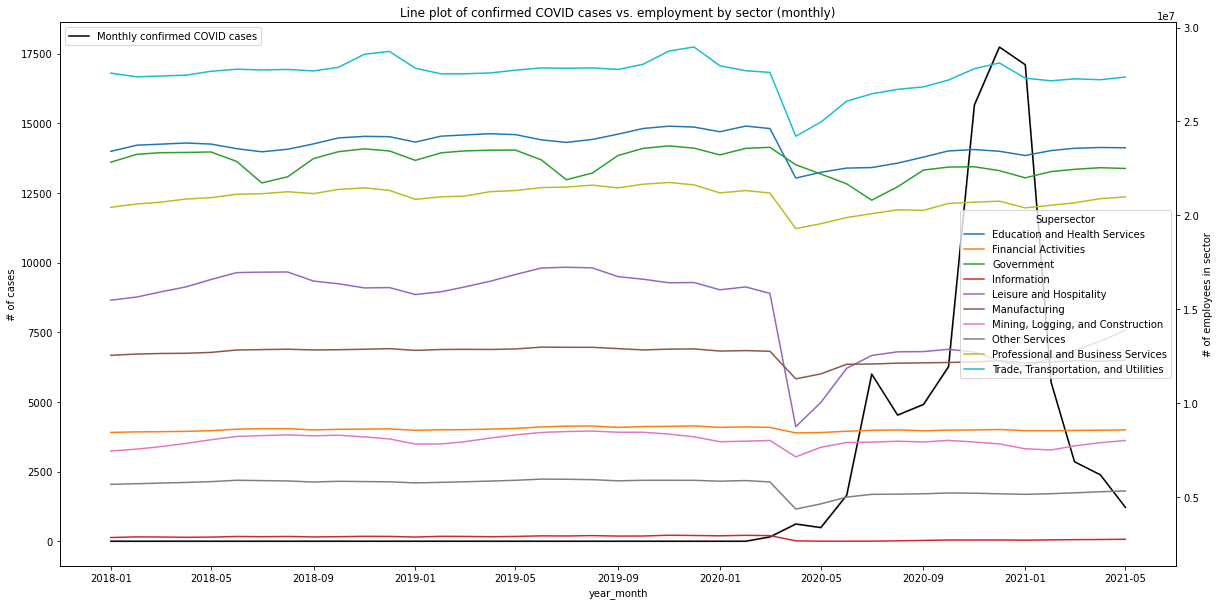

In [54]:
plt.figure(figsize=(20,10))
employment_by_sector_OK_cases['year_month']=pd.to_datetime(employment_by_sector_OK_cases['year_month'])
employment_by_sector_OK_cases_temp = employment_by_sector_OK_cases[(employment_by_sector_OK_cases['year_month'] >= '2018-01-01') & (employment_by_sector_OK_cases['year_month'] <= '2021-10-01')]
ax1 = sns.lineplot(x="year_month", y="daily_cases" , color="black",data=employment_by_sector_OK_cases_temp, legend=False)
ax1.legend(['Monthly confirmed COVID cases'], loc="upper left")
ax1.set_ylabel('# of cases')
ax2 = plt.twinx()
sns.lineplot(x="year_month", y="NSA Employees", hue='Supersector', color="b", ax=ax2,data=employment_by_sector_OK_cases_temp)
#ax2.legend(['Monthly current employees in sector'], loc="upper right")
ax2.set_ylabel('# of employees in sector')
ax1.set_title("Line plot of confirmed COVID cases vs. employment by sector (monthly)")
plt.savefig('../results/Line plot of confirmed COVID cases vs. employment by sector (monthly).png',bbox_inches='tight')

We can observe that many of the sectors seem to fail to recuperate from the layoff, especially Information seems to not recuperate at all. We want to get a better view of this:

#### 4.4.2 Post-pandemic percentage of recovered layoffs by sector with bar-graph

In [55]:
#We find for each sector the minimum number of employees after the pandemic
min_employees_post_pandemic = employment_by_sector_OK_cases[employment_by_sector_OK_cases['year_month']>day_first_COVID_OK][['Supersector','NSA Employees']].groupby('Supersector').min()
min_employees_post_pandemic.rename(columns={'NSA Employees':'min_employees_post_pandemic'}, inplace=True)
#We find for each sector the last number of employees we have in records
last_employees_post_pandemic = employment_by_sector_OK_cases[['Supersector','NSA Employees']].groupby('Supersector').last()
last_employees_post_pandemic.rename(columns={'NSA Employees':'last_employees_post_pandemic'}, inplace=True)
#We find the number of employees that each sector had the month right before the pandemic hits (February)
employees_start_pandemic = employment_by_sector_OK_cases[employment_by_sector_OK_cases['year_month']=='2020-02-01'][['Supersector','NSA Employees']]
employees_start_pandemic.rename(columns={'NSA Employees':'employees_start_pandemic'}, inplace=True)
#We join employees_start_pandemic with min_employees_post_pandemic
joint_table = employees_start_pandemic.merge(min_employees_post_pandemic, on='Supersector')
#We calcuate the layoff for each sector
joint_table['pandemic_layoff'] = joint_table['employees_start_pandemic'] - joint_table['min_employees_post_pandemic']
#We join the last_employees_post_pandemic table
joint_table = joint_table.merge(last_employees_post_pandemic, on='Supersector')
#We calculate the number of employees recovered after the layoff
joint_table['employees_recovered'] = joint_table['last_employees_post_pandemic'] - joint_table['min_employees_post_pandemic']
#We calculate the percentage recovered
joint_table['percentage_recovered'] = joint_table['employees_recovered']*100/joint_table['pandemic_layoff']

In [56]:
joint_table

,Supersector,employees_start_pandemic,min_employees_post_pandemic,pandemic_layoff,last_employees_post_pandemic,employees_recovered,percentage_recovered
0,Education and Health Services,24748300.0,21977600.0,2770700.0,23592300.0,1614700.0,58.277692
1,Financial Activities,8720300.0,8398100.0,322200.0,8560600.0,162500.0,50.434513
2,Government,23561500.0,20799800.0,2761700.0,22489800.0,1690000.0,61.194192
3,Information,2942700.0,2630400.0,312300.0,2732400.0,102000.0,32.660903
4,Leisure and Hospitality,16177400.0,8732700.0,7444700.0,13867900.0,5135200.0,68.977931
5,Manufacturing,12785200.0,11280000.0,1505200.0,12276600.0,996600.0,66.210470
6,"Mining, Logging, and Construction",7959900.0,7122900.0,837000.0,7994900.0,872000.0,104.181601
7,Other Services,5860600.0,4343000.0,1517600.0,5307200.0,964200.0,63.534528
8,Professional and Business Services,21313300.0,19282500.0,2030800.0,20975300.0,1692800.0,83.356313
9,"Trade, Transportation, and Utilities",27696800.0,24208700.0,3488100.0,27360200.0,3151500.0,90.350047


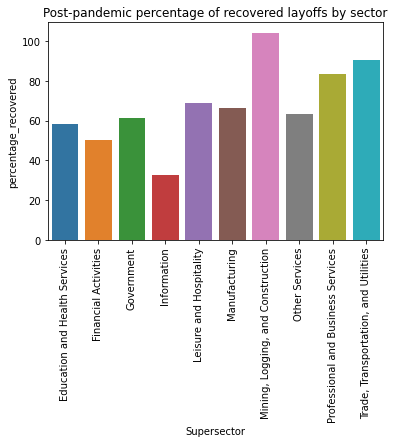

In [57]:
#Create the barplot for the post-pandemic percentage of recovered layoffs by sector 
bar_recovered = sns.barplot(data=joint_table,x='Supersector',y='percentage_recovered')
bar_recovered.tick_params(axis='x', labelrotation = 90)
bar_recovered.set(title='Post-pandemic percentage of recovered layoffs by sector')
plt.savefig('../results/Bar plot of post-pandemic percentage of recovered layoffs by sector.png',bbox_inches='tight')

We can notice that not all sectors have been able to recuperate equally. Sectors such as Mining, Logging and Construction were able to have even more jobs than before, while others such as Information havent been able to recuperate more than 1/3 of what they lost. 